# AI Art Detector - Binary Image Classifier

Import Libraries

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

Loading Dataset

In [2]:
# dataset class handles custom dataset
class ArtDataset(Dataset):
    def __init__(self, data_path, df, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        # extracts image paths and labels from csv file
        self.img_path = df.iloc[:,0].tolist()
        self.img_label = df.iloc[:,1].tolist()
    
    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, idx):
        # retrieve file name and label for given index
        file_name = self.img_path[idx]
        label = self.img_label[idx]

        # open image (removes corrupted files)
        img = Image.open(os.path.join(self.data_path, file_name))

        # apply transformations
        if self.transform:
            img = self.transform(img)

        # return image and label as tuple
        return img, label

In [3]:
# define image transformations
interpolation_mode = transforms.InterpolationMode.BICUBIC
resize_transform = transforms.Resize((50,50), interpolation=interpolation_mode)
transform = transforms.Compose([
                            resize_transform,
                            transforms.Grayscale(num_output_channels=1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,)),
                        ])
    
data_path= 'ArtDataset/'
file_path = 'img_data.csv'

# read the csv file into dataframe
img_data = pd.read_csv(file_path)

# create instance of dataset
full_dataset = ArtDataset(data_path=data_path, df=img_data, transform=transform)

# length of dataset after processing
print("length of dataset:", full_dataset.__len__())

length of dataset: 8678


In [4]:
# define train and test ratio
train_ratio = 0.80
test_ratio = 1.0 - train_ratio

# calculate amount of samples
all_data = len(full_dataset)
train_data = int(train_ratio * all_data)
test_data = all_data - train_data

# randomly split into train and test dataset
train_dataset, test_dataset = random_split(full_dataset, [train_data, test_data])

# create dataloader instances, shuffles during each epoch/evalution
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# length of datasets after splitting
print("training images:", len(train_dataset))
print("testing images:", len(test_dataset))

training images: 6942
testing images: 1736


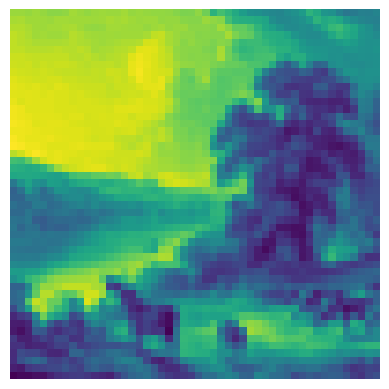

In [6]:
# shows random image from the train dataset
images, labels = next(iter(train_loader))
ex_img1 = images[10][0]

plt.imshow(ex_img1.numpy())
plt.axis('off')
plt.show()

CNN

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
    
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid() # for binary classification
        )

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x,(1,1))
        x = x.view(x.size(0), -1) # flatten tensor
        x = self.fc(x)

        return x

In [25]:
# init neural network
net = Net()
print(net)
summary(net, (1, 50,50))

Net(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(

Training

In [10]:
# define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.0025)
loss_function = nn.MSELoss()

In [13]:
epochs = 25

#set neural network to training mode
net.train()

for epoch in range(epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # zero gradients to prevent accumulation from previous iterations
        optimizer.zero_grad()

        # forward pass: compute the output of the neural network
        output = net(x).reshape(-1)

        # loss between predicted output and label
        loss = loss_function(output, y.to(torch.float32))

        # backward pass: compute gradients and update the neural network parameters
        loss.backward()
        optimizer.step()
        
        # update running loss for current epoch
        train_loss += loss.item()
        
        # count correct predictions for accuracy
        predicted = (output > 0.5).float()
        correct += (predicted == y).sum().item()
        total += y.size(0)
        
    # calculate accuracy
    if total > 0:
        accuracy = correct / total

    # accuracy and loss    
    print(f'accuracy: {accuracy:.2%}')
    print("epoch:", (epoch + 1), "loss:", (train_loss))

print('done training.')

100%|█████████████████████████████████████████| 217/217 [04:27<00:00,  1.23s/it]


accuracy: 71.16%
epoch: 1 loss: 41.18654044345021


100%|█████████████████████████████████████████| 217/217 [04:40<00:00,  1.29s/it]


accuracy: 77.17%
epoch: 2 loss: 34.5058306902647


100%|█████████████████████████████████████████| 217/217 [04:38<00:00,  1.28s/it]


accuracy: 78.87%
epoch: 3 loss: 32.004312101751566


100%|█████████████████████████████████████████| 217/217 [04:35<00:00,  1.27s/it]


accuracy: 80.52%
epoch: 4 loss: 29.949683915823698


100%|█████████████████████████████████████████| 217/217 [04:33<00:00,  1.26s/it]


accuracy: 81.46%
epoch: 5 loss: 28.351133581250906


100%|█████████████████████████████████████████| 217/217 [04:32<00:00,  1.26s/it]


accuracy: 83.91%
epoch: 6 loss: 25.34126214683056


100%|█████████████████████████████████████████| 217/217 [04:36<00:00,  1.27s/it]


accuracy: 84.41%
epoch: 7 loss: 23.965687615796924


100%|█████████████████████████████████████████| 217/217 [04:38<00:00,  1.28s/it]


accuracy: 86.34%
epoch: 8 loss: 21.685598455369473


100%|█████████████████████████████████████████| 217/217 [04:28<00:00,  1.24s/it]


accuracy: 88.00%
epoch: 9 loss: 18.876355497166514


100%|█████████████████████████████████████████| 217/217 [04:34<00:00,  1.26s/it]


accuracy: 89.20%
epoch: 10 loss: 17.872485834173858


100%|█████████████████████████████████████████| 217/217 [04:26<00:00,  1.23s/it]


accuracy: 90.59%
epoch: 11 loss: 15.44040494877845


100%|█████████████████████████████████████████| 217/217 [04:22<00:00,  1.21s/it]


accuracy: 91.83%
epoch: 12 loss: 13.735944310668856


100%|█████████████████████████████████████████| 217/217 [04:28<00:00,  1.24s/it]


accuracy: 92.21%
epoch: 13 loss: 12.579221100080758


100%|█████████████████████████████████████████| 217/217 [04:23<00:00,  1.22s/it]


accuracy: 94.31%
epoch: 14 loss: 9.736695016734302


100%|█████████████████████████████████████████| 217/217 [04:25<00:00,  1.23s/it]


accuracy: 94.48%
epoch: 15 loss: 8.946463817323092


100%|█████████████████████████████████████████| 217/217 [04:25<00:00,  1.22s/it]


accuracy: 95.62%
epoch: 16 loss: 7.500586459507758


100%|█████████████████████████████████████████| 217/217 [04:28<00:00,  1.24s/it]


accuracy: 96.13%
epoch: 17 loss: 6.452352021617116


100%|█████████████████████████████████████████| 217/217 [04:30<00:00,  1.25s/it]


accuracy: 96.60%
epoch: 18 loss: 6.084111893738736


100%|█████████████████████████████████████████| 217/217 [04:22<00:00,  1.21s/it]


accuracy: 96.85%
epoch: 19 loss: 5.521094202682434


100%|█████████████████████████████████████████| 217/217 [04:20<00:00,  1.20s/it]


accuracy: 97.23%
epoch: 20 loss: 5.012087630326278


100%|█████████████████████████████████████████| 217/217 [04:20<00:00,  1.20s/it]


accuracy: 97.49%
epoch: 21 loss: 4.498722397049278


100%|█████████████████████████████████████████| 217/217 [04:33<00:00,  1.26s/it]


accuracy: 97.44%
epoch: 22 loss: 4.63992959324969


100%|█████████████████████████████████████████| 217/217 [04:31<00:00,  1.25s/it]


accuracy: 97.34%
epoch: 23 loss: 4.53908746576144


100%|█████████████████████████████████████████| 217/217 [04:34<00:00,  1.27s/it]


accuracy: 97.94%
epoch: 24 loss: 3.770326573858256


100%|█████████████████████████████████████████| 217/217 [04:27<00:00,  1.23s/it]

accuracy: 98.00%
epoch: 25 loss: 3.832775866443342
done training.


Testing

In [14]:
# set neural network to evaluation mode
net.eval()

correct = 0
total = 0

# init loss
test_loss = 0.0

# disable gradient computation for evaluation
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # forward pass: compute the output of the neural network
        output = net(x).reshape(-1)
        
        # threshold of 0.5 to convert output probabilities to binary predictions
        predicted = (output > 0.5).float()
        
        # count correct predictions
        correct += (predicted == y).sum().item()
        total += y.size(0)
        
        # record loss
        loss = loss_function(output, y.to(torch.float32))
        test_loss += loss.item()
        
# calculate accuracy
if total > 0:
    accuracy = correct / total

print(f'accuracy: {accuracy:.2%}')
print("loss:", (test_loss))  

100%|███████████████████████████████████████████| 55/55 [00:37<00:00,  1.46it/s]


accuracy: 86.35%
loss: 6.384865667154372


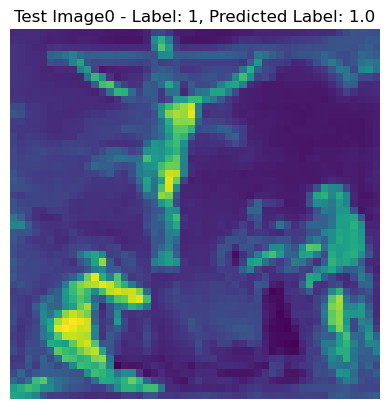

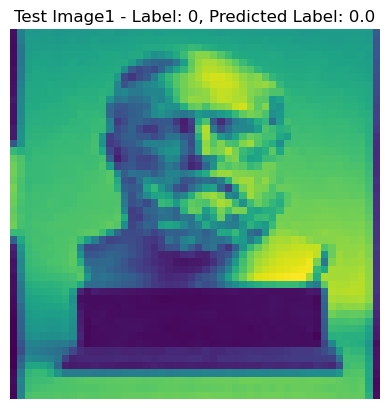

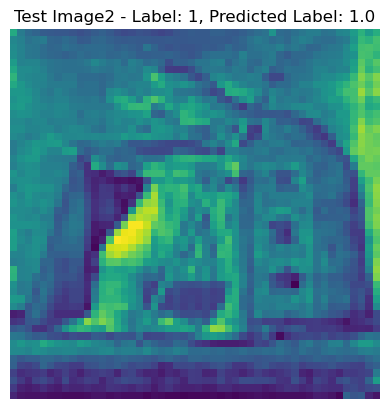

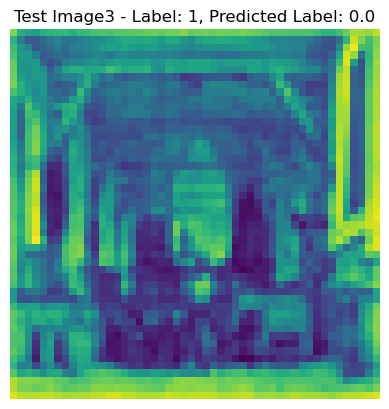

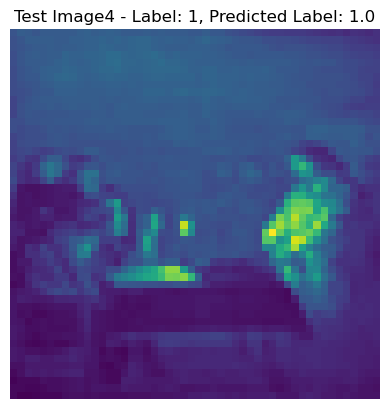

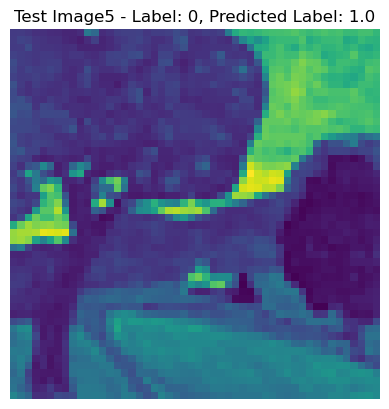

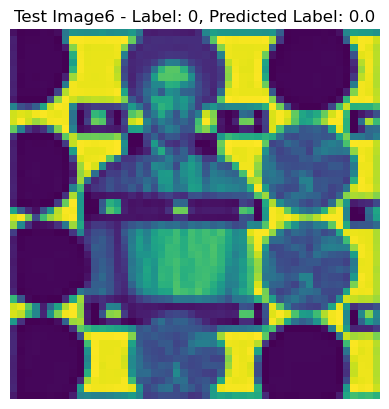

In [22]:
# show a batch of images from the test loader with real label and predicted label
images, labels = next(iter(test_loader))

for i in range(0,7):
    plt.imshow(images[i][0])
    plt.title(f"Test Image{i} - Label: {labels[i]}, Predicted Label: {predicted[i]}")
    plt.axis('off')
    plt.show()

Save Model

In [23]:
try:
    torch.save(net.state_dict(), 'AIArtClassifier_statedict.pth') # saves as state dict
    torch.save(net,'AIArtClassifier_model.pth') # saves entire model
except Exception as e:
    print("error saving model: {e}")